In [18]:
!pip install -q rdkit

In [1]:
import warnings # suppress warnings
warnings.filterwarnings('ignore')

import os
import gc
import glob
import random
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from pathlib import Path
from itertools import groupby

import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
!ls ../input/*

../input/cell-type-embeddings:
cell_type_embeddings.csv

../input/open-problems-single-cell-perturbations:
adata_excluded_ids.csv	de_train.parquet       multiome_train.parquet
adata_obs_meta.csv	id_map.csv	       multiome_var_meta.csv
adata_train.parquet	multiome_obs_meta.csv  sample_submission.csv


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
de_train = pd.read_parquet('../input/open-problems-single-cell-perturbations/de_train.parquet')
de_train.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [4]:
id_map = pd.read_csv('../input/open-problems-single-cell-perturbations/id_map.csv')
id_map.head()

,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867


In [5]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

chemberta = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
import torch

def get_smiles_embeddings(_model, _tokenizer, _smiles_list):
    _model.eval()
    embeddings = torch.zeros(len(_smiles_list), 600)
    embeddings_mean = torch.zeros(len(_smiles_list), 600)
    with torch.no_grad():
        for i, smiles in enumerate(tqdm(_smiles_list)):
            encoded_input = _tokenizer(smiles, return_tensors="pt", padding=False, truncation=True)
            model_output = _model(**encoded_input)
            embedding = model_output[0][::,0,::]
            embeddings[i] = embedding
            embedding = torch.mean(model_output[0], 1)
            embeddings_mean[i] = embedding
    
    return embeddings.numpy(), embeddings_mean.numpy()

In [10]:
# Get unique values from the SMILES column
smiles_list = list(set(de_train['SMILES'].values))

In [11]:
from collections import defaultdict

def construct_smiles_table(_data):
    smiles_table = defaultdict(set)

    sm_compounds_values = _data['sm_name'].values
    smiles_values = _data['SMILES'].values
    
    for (_sm_name, _smiles) in zip(sm_compounds_values, smiles_values):
        smiles_table[_sm_name].add(_smiles)
    
    for _sm_name in id_map['sm_name'].values:
        assert len(smiles_table[_sm_name]) == 1, "Yikes!"
    
    return smiles_table

In [12]:
smiles_table = construct_smiles_table(de_train)

In [13]:
list(smiles_table.items())[:5]

[('Clotrimazole', {'Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1'}),
 ('Mometasone Furoate',
  {'C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(Cl)[C@@H](O)C[C@]2(C)[C@@]1(OC(=O)c1ccco1)C(=O)CCl'}),
 ('Idelalisib', {'CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n1-c1ccccc1'}),
 ('Vandetanib', {'COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1'}),
 ('Bosutinib',
  {'COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc23)c(Cl)cc1Cl'})]

In [14]:
train_df = de_train[:int(len(de_train) * .8)]
val_df = de_train[int(len(de_train) * .8):]

In [15]:
train_df

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,T cells CD4+,Defactinib,LSM-45153,CNC(=O)c1ccc(Nc2ncc(C(F)(F)F)c(NCc3nccnc3N(C)S...,False,-0.643798,-0.565920,1.089216,-0.338604,-0.238554,...,0.754069,-0.636432,-0.712187,-0.215407,0.098187,-0.122556,-0.039378,0.011757,0.261196,-0.345325
487,T cells CD8+,Defactinib,LSM-45153,CNC(=O)c1ccc(Nc2ncc(C(F)(F)F)c(NCc3nccnc3N(C)S...,False,0.034232,-0.279428,-0.640393,-0.729563,0.308592,...,-0.894871,-0.195603,-0.212170,0.136398,-0.608969,0.242280,0.151420,-0.786194,0.247923,0.025524
488,T regulatory cells,Defactinib,LSM-45153,CNC(=O)c1ccc(Nc2ncc(C(F)(F)F)c(NCc3nccnc3N(C)S...,False,0.088045,-0.740291,0.186575,-0.054177,0.236731,...,-0.371045,-0.151009,0.311892,-0.078271,0.394437,0.098308,-0.011042,-0.371461,0.368083,-0.184608
489,NK cells,PF-04691502,LSM-45239,COc1ccc(-c2cc3c(C)nc(N)nc3n([C@H]3CC[C@H](OCCO...,False,0.559325,-0.094944,-0.054357,-0.335232,-0.246568,...,-0.688867,0.810529,0.057064,0.525448,-0.378893,-0.050545,-0.007520,-0.236496,-0.045047,0.276947


In [16]:
val_df

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
491,T cells CD8+,PF-04691502,LSM-45239,COc1ccc(-c2cc3c(C)nc(N)nc3n([C@H]3CC[C@H](OCCO...,False,1.795443,0.189875,1.716503,2.459436,0.057301,...,0.297697,0.188203,0.327016,0.087177,0.307394,-0.022856,0.089586,-0.133742,-0.299079,0.589353
492,T regulatory cells,PF-04691502,LSM-45239,COc1ccc(-c2cc3c(C)nc(N)nc3n([C@H]3CC[C@H](OCCO...,False,1.894573,1.293410,3.554511,2.358117,3.732430,...,1.091362,0.881981,3.207406,2.061079,2.420289,2.218458,0.312913,0.598545,-1.433828,-0.068473
493,NK cells,GLPG0634,LSM-45924,O=C(Nc1nc2cccc(-c3ccc(CN4CCS(=O)(=O)CC4)cc3)n2...,False,1.437935,0.302079,-0.017537,-0.243588,0.847305,...,0.204522,-0.513846,0.656632,-0.004115,-0.328443,-0.179321,0.469310,-0.132645,0.344745,0.087165
494,T cells CD4+,GLPG0634,LSM-45924,O=C(Nc1nc2cccc(-c3ccc(CN4CCS(=O)(=O)CC4)cc3)n2...,False,0.051677,-0.374778,1.126718,0.666192,-0.261607,...,-0.618753,-0.129363,0.462115,-0.461896,0.523743,1.080247,1.659195,2.875106,0.457703,0.363809
495,T cells CD8+,GLPG0634,LSM-45924,O=C(Nc1nc2cccc(-c3ccc(CN4CCS(=O)(=O)CC4)cc3)n2...,False,-0.638282,0.243295,-0.148159,0.066220,0.075536,...,0.128929,-0.544734,-0.013238,-0.578998,-0.343394,-0.534739,0.150862,-0.286436,0.279185,0.351312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [19]:
# Assuming you have a DataFrame 'df' with columns 'sm_name', 'cell_type', and 'smiles'
# df = pd.DataFrame(data)
from rdkit import Chem
from rdkit.Chem import AllChem
import random

def generate_smiles_enumerations(smiles, num_variants=10):
    mol = Chem.MolFromSmiles(smiles)
    enumerated_smiles = set()

    for _ in range(num_variants):
        new_order = list(range(mol.GetNumAtoms()))
        random.shuffle(new_order)
        randomized_mol = Chem.RenumberAtoms(mol, new_order)
        new_smiles = Chem.MolToSmiles(randomized_mol, canonical=False)
        enumerated_smiles.add(new_smiles)

    return list(enumerated_smiles)

def augment_data_with_smiles_variants(df, num_variants=10):
    augmented_rows = []

    for _, row in df.iterrows():
        original_smiles = row['SMILES']

        # Generate SMILES variants
        smiles_variants = generate_smiles_enumerations(original_smiles, num_variants)

        for variant in smiles_variants:
            augmented_row = row.copy()  # Copy the entire row
            augmented_row['SMILES'] = variant  # Update only the SMILES column
            augmented_rows.append(augmented_row)

    # Create a new DataFrame from the augmented rows
    augmented_df = pd.DataFrame(augmented_rows)
    return pd.concat([df, augmented_df], ignore_index=True)

# Apply the function to your DataFrame
# augmented_df = augment_data_with_smiles_variants(train_df, num_variants=10)
augmented_df = train_df


In [20]:
cell_type_embeddings = pd.read_csv('../input/cell-type-embeddings/cell_type_embeddings.csv').set_index('cell_type')
cell_type_embeddings

,0,1,2,3,4,5,6,7,8,9,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
cell_type,,,,,,,,,,,,,,,,,,,,,
B cells,-0.164826,-1.057380,3.514953,0.044016,-0.103250,0.104517,-0.022501,-0.009548,-0.006623,-0.020086,...,-0.000043,-0.000144,0.000505,-0.000352,0.000107,-0.000114,-0.000298,-0.000454,-0.000445,0.000735
Myeloid cells,4.050744,-1.029732,-0.773158,-0.102245,0.001597,-0.008456,0.009523,0.024920,0.045712,-0.006609,...,-0.000516,-0.000235,-0.000160,0.000091,0.000591,-0.000329,-0.000719,0.000306,0.000040,0.000017
NK cells,-1.483395,0.775050,-0.581633,1.979790,0.004260,-0.261135,-0.069128,-0.006701,-0.076228,-0.080109,...,0.000090,0.001457,0.000251,-0.000345,0.000022,0.000182,0.000635,-0.000641,-0.000438,-0.000998
T cells CD4+,-2.008946,0.730508,-0.557379,-0.810206,-0.015345,0.115020,0.002712,-0.035889,0.007277,0.057749,...,0.000230,-0.000593,0.000157,0.000031,-0.000675,-0.000103,0.000272,-0.000152,0.000108,0.000767
T cells CD8+,-1.772123,0.927888,-0.224138,-1.072140,0.593933,-0.683676,-0.588880,-0.113141,-0.261219,-0.232482,...,0.000907,0.004792,-0.004919,0.002062,0.003976,-0.001849,0.001853,0.002291,0.007308,-0.002840
T regulatory cells,-1.666848,0.617034,-0.246139,-0.469218,0.417135,0.210979,1.229367,0.587386,0.240460,0.120172,...,0.001407,-0.002584,-0.001882,0.001882,-0.000555,0.007685,-0.000544,0.005625,-0.002708,-0.008486


In [21]:
smiles_embeddings_train, smiles_embeddings_mean_train = get_smiles_embeddings(chemberta, tokenizer, augmented_df['SMILES'])

100%|██████████| 491/491 [00:04<00:00, 118.02it/s]


In [22]:
smiles_embeddings_val, smiles_embeddings_mean_val = get_smiles_embeddings(chemberta, tokenizer, val_df['SMILES'])

100%|██████████| 123/123 [00:01<00:00, 121.33it/s]


In [23]:
X_test_smiles = np.array([list(smiles_table[_sm_name])[0] for _sm_name in id_map['sm_name']])

In [24]:
smiles_embeddings_test, smiles_embeddings_mean_test = get_smiles_embeddings(chemberta, tokenizer, X_test_smiles)

100%|██████████| 255/255 [00:01<00:00, 127.79it/s]


In [25]:
cell_type_embeddings_train = cell_type_embeddings.loc[augmented_df['cell_type'].values].values
cell_type_embeddings_train.shape

(491, 15000)

In [26]:
cell_type_embeddings_val = cell_type_embeddings.loc[val_df['cell_type'].values].values
cell_type_embeddings_val.shape

(123, 15000)

In [27]:
cell_type_embeddings_test = cell_type_embeddings.loc[id_map['cell_type'].values].values
cell_type_embeddings_test.shape

(255, 15000)

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fit the encoder on the combined data
categorical_encoder = OneHotEncoder()
categorical_encoder.fit(de_train[['cell_type', 'sm_name']])

# Transform training and validation data separately
cell_sm_encoded_train = categorical_encoder.transform(augmented_df[['cell_type', 'sm_name']]).toarray()
cell_sm_encoded_val = categorical_encoder.transform(val_df[['cell_type', 'sm_name']]).toarray()
cell_sm_encoded_test = categorical_encoder.transform(id_map[['cell_type', 'sm_name']]).toarray()

# Standardize gene expression values
# scaler = MinMaxScaler()
# y_train = scaler.fit_transform(augmented_df.iloc[:, 5:])
# y_val = scaler.transform(val_df.iloc[:, 5:]) 

y_train = train_df.iloc[:, 5:].values
y_val = val_df.iloc[:, 5:].values

print(y_train.shape, y_val.shape, cell_sm_encoded_train.shape, cell_sm_encoded_val.shape)

(491, 18211) (123, 18211) (491, 152) (123, 152)


In [29]:
import tensorflow as tf

def mrrmse(y_true, y_pred):
    # Mean Squared Error for each row
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    
    # Root Mean Squared Error for each row
    rmse = tf.sqrt(mse)
    
    # Mean Rowwise Root Mean Squared Error
    mrrmse = tf.reduce_mean(rmse)
    
    return mrrmse

In [30]:
import keras
from keras.layers import Input, Dense, Dropout, Concatenate, Reshape, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.models import Model
from keras.regularizers import l1_l2

def model_1():
    # Assuming the categorical features and ChemBERTa embeddings are already preprocessed
    num_categorical_features = cell_sm_encoded_train.shape[1]
    num_genes = 18211  # Number of genes to predict

    # Input Layers
    input_cell_type_embeddings = Input(shape=(15000,), name='cell_type_embeddings')
    input_categorical = Input(shape=(num_categorical_features,), name='categorical_features')
    input_chemberta_embeddings = Input(shape=(600,), name='chemberta_embeddings')

    # CNN Branch for cell_type embeddings
    reshaped_cell_type_embeddings = Reshape((15000, 1))(input_cell_type_embeddings)
    cnn_branch_cell_type = Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(reshaped_cell_type_embeddings)
    cnn_branch_cell_type = MaxPooling1D(pool_size=2)(cnn_branch_cell_type)
    cnn_branch_cell_type = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(cnn_branch_cell_type)
    cnn_branch_cell_type = MaxPooling1D(pool_size=2)(cnn_branch_cell_type)
    cnn_branch_cell_type = Flatten()(cnn_branch_cell_type)
    cnn_branch_cell_type = Dropout(0.5)(cnn_branch_cell_type)

    # Dense Branch for Categorical Features
    dense_branch_cat = Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(input_categorical)
    dense_branch_cat = BatchNormalization()(dense_branch_cat)
    dense_branch_cat = Dropout(0.5)(dense_branch_cat)

    # Dense Branch for ChemBERTa Embeddings
    dense_branch_chemberta = Dense(256, activation='relu')(input_chemberta_embeddings)
    dense_branch_chemberta = BatchNormalization()(dense_branch_chemberta)
    dense_branch_chemberta = Dropout(0.3)(dense_branch_chemberta)
    dense_branch_chemberta = Dense(128, activation='relu')(dense_branch_chemberta)
    dense_branch_chemberta = Dropout(0.2)(dense_branch_chemberta)

    # Concatenation
    concat = Concatenate()([cnn_branch_cell_type, dense_branch_cat, dense_branch_chemberta])

    # Fully Connected Layers
    fc = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(concat)
    fc = BatchNormalization()(fc)
    fc = Dropout(0.5)(fc)
    fc = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(fc)
    fc = Dropout(0.5)(fc)

    # Output Layer for Regression
    output = Dense(num_genes)(fc)  # Linear activation for regression

    # Build and Compile the Model
    model = Model(inputs=[input_cell_type_embeddings, input_categorical, input_chemberta_embeddings], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', mrrmse])

    # Model Summary
    model.summary()
    
    return model

In [33]:
import keras
from keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

def model_2():
    # Assuming the categorical features and SMILES embeddings are preprocessed
    num_categorical_features = cell_sm_encoded_train.shape[1]
    num_smiles_features = 600  # Adjust based on your data
    num_genes = 18211  # Number of genes to predict

    # Input Layers
    input_categorical = Input(shape=(num_categorical_features,), name='categorical_features')
    input_smiles = Input(shape=(num_smiles_features,), name='smiles_embeddings')

    # Dense Branch for Categorical Features
    dense_branch_cat = Dense(256, activation='relu')(input_categorical)
    dense_branch_cat = BatchNormalization()(dense_branch_cat)
    dense_branch_cat = Dropout(0.3)(dense_branch_cat)

    # Dense Branch for SMILES Embeddings
    dense_branch_smiles = Dense(256, activation='relu')(input_smiles)
    dense_branch_smiles = BatchNormalization()(dense_branch_smiles)
    dense_branch_smiles = Dropout(0.3)(dense_branch_smiles)
    dense_branch_smiles = Dense(128, activation='relu')(dense_branch_smiles)
    dense_branch_smiles = Dropout(0.2)(dense_branch_smiles)

    # Concatenation
    concat = Concatenate()([dense_branch_cat, dense_branch_smiles])

    # Fully Connected Layers
    fc = Dense(1024, activation='relu')(concat)
    fc = BatchNormalization()(fc)
    fc = Dropout(0.4)(fc)
    fc = Dense(512, activation='relu')(fc)
    fc = Dropout(0.3)(fc)
    fc = Dense(256, activation='relu')(fc)
    fc = Dropout(0.2)(fc)

    # Additional layers to increase model capacity
    fc = Dense(256, activation='relu')(fc)
    fc = BatchNormalization()(fc)
    fc = Dropout(0.2)(fc)
    fc = Dense(128, activation='relu')(fc)
    fc = Dropout(0.2)(fc)

    # Output Layer for Regression
    output = Dense(num_genes)(fc)  # Linear activation for regression

    # Build the Model
    model = Model(inputs=[input_categorical, input_smiles], outputs=output)

    # Compile the Model
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error', metrics=['mean_absolute_error', mrrmse])

    # Model Summary
    model.summary()
    
    return model

In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.backend import clear_session

def train_model(_model, _train_input, _val_input, _train_output, _val_output, save_file, batch_size=128, epochs=100):
    # Callbacks
    checkpoint_filepath = save_file
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    clear_session()

    # Fit the model with separate validation data
    history = _model.fit(_train_input, _train_output, 
              batch_size=batch_size, 
              epochs=epochs, 
              validation_data=(_val_input, _val_output),
              callbacks=[model_checkpoint_callback, early_stopping_callback])
    
    return history

import matplotlib.pyplot as plt

def plot_history(history, metric, title):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric], '-', label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

In [34]:
from tensorflow.keras.backend import clear_session

cell_sm_smiles_model_unaugmented = model_2()
history_2_unaugmented = train_model(cell_sm_smiles_model_unaugmented,
                        [cell_sm_encoded_train, smiles_embeddings_train], 
                        [cell_sm_encoded_val, smiles_embeddings_val],
                        y_train,
                        y_val,
                        "cell_sm_smiles_unaugmented",
                        batch_size=5,
                        epochs=50)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 smiles_embeddings (InputLayer)  [(None, 600)]       0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 256)          153856      ['smiles_embeddings[0][0]']      
                                                                                                  
 categorical_features (InputLay  [(None, 152)]       0           []                               
 er)                                                                                              
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256)         1024        ['dense_1[0][0]']            

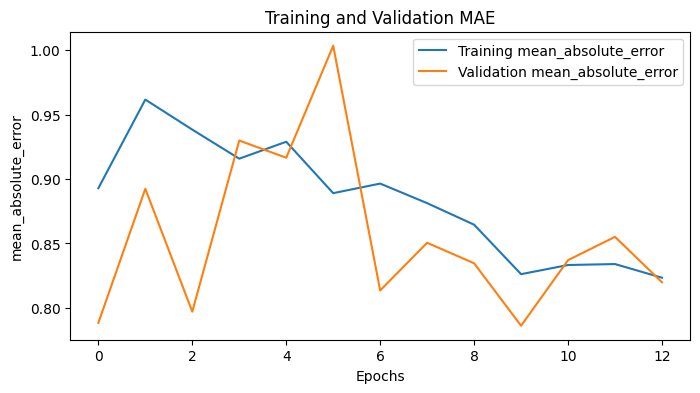

In [37]:
plot_history(history_2_unaugmented, 'mean_absolute_error', 'Training and Validation MAE')

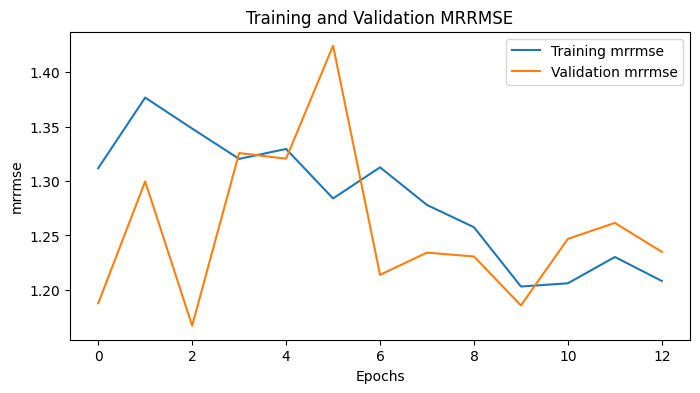

In [38]:
plot_history(history_2_unaugmented, 'mrrmse', 'Training and Validation MRRMSE')

In [39]:
from tensorflow.keras.backend import clear_session

hybrid_model_unaugmented = model_1()
history_hybrid_unaugmented = train_model(hybrid_model_unaugmented,
                        [cell_type_embeddings_train, cell_sm_encoded_train, smiles_embeddings_train], 
                        [cell_type_embeddings_val, cell_sm_encoded_val, smiles_embeddings_val],
                        y_train,
                        y_val,
                        "hybrid_unaugmented",
                        batch_size=128,
                        epochs=50)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cell_type_embeddings (InputLay  [(None, 15000)]     0           []                               
 er)                                                                                              
                                                                                                  
 reshape (Reshape)              (None, 15000, 1)     0           ['cell_type_embeddings[0][0]']   
                                                                                                  
 conv1d (Conv1D)                (None, 14998, 128)   512         ['reshape[0][0]']                
                                                                                                  
 chemberta_embeddings (InputLay  [(None, 600)]       0           []                           

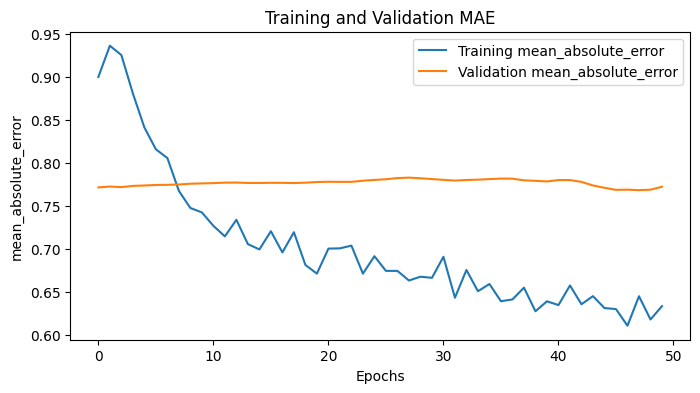

In [40]:
plot_history(history_hybrid_unaugmented, 'mean_absolute_error', 'Training and Validation MAE')

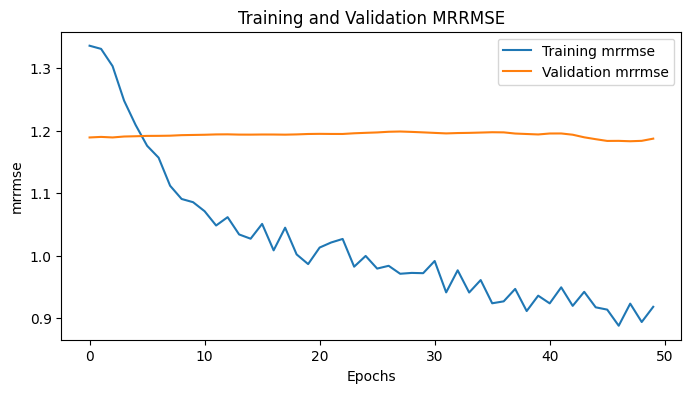

In [41]:
plot_history(history_hybrid_unaugmented, 'mrrmse', 'Training and Validation MRRMSE')

In [ ]:
from tensorflow.keras.backend import clear_session

clear_session()

# Fit the model with separate validation data
history = model.fit([cell_type_embeddings_train, cell_sm_encoded_train, smiles_embeddings_mean_train], y_train, 
          batch_size=128, 
          epochs=100, 
          validation_data=([cell_type_embeddings_val, cell_sm_encoded_val, smiles_embeddings_mean_val], y_val),
          callbacks=[model_checkpoint_callback, early_stopping_callback])

In [ ]:
from tensorflow.keras.backend import clear_session

cell_sm_smiles_model = model_2()
history_2 = train_model(cell_sm_smiles_model,
                        [cell_sm_encoded_train, smiles_embeddings_mean_train], 
                        [cell_sm_encoded_val, smiles_embeddings_mean_val],
                        y_train,
                        y_val,
                        "cell_sm_smiles",
                        batch_size=5,
                        epochs=50)

In [ ]:
plot_history(history_2, 'mean_absolute_error', 'Training and Validation MAE')

In [ ]:
test_submission = cell_sm_smiles_model([cell_sm_encoded_test, smiles_embeddings_mean_test])

In [ ]:
# Create a dataframe from test_submission with column names from de_train, except for the first 5 columns
test_submission_df = pd.DataFrame(test_submission, columns=de_train.columns[5:])

# Add an id column to the left of the test submission with values from 0 till the end
test_submission_df

In [ ]:
# Add an 'id' column
test_submission_df['id'] = test_submission_df.index

# Set the 'id' column as the index
test_submission_df.set_index('id', inplace=True)

In [ ]:
test_submission_df

In [ ]:
test_submission_df.to_csv("submission.csv")

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import l1_l2

def create_cnn_lstm_model(max_smiles_length, vocab_size, num_genes, embedding_dim, initial_conv_filters, kernel_size, 
                          pool_size, lstm_units, num_categories, num_conv_layers, num_dense_layers, learning_rate,
                          dropout_rate, l1_reg, l2_reg):
    """
    """
    
    # SMILES input branch with multiple CNN layers
    smiles_input = Input(shape=(max_smiles_length,))
    x = Embedding(vocab_size, embedding_dim)(smiles_input)

    for i in range(num_conv_layers):
        num_filters = initial_conv_filters * (2 ** i)
        x = Conv1D(num_filters, kernel_size, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
        x = MaxPooling1D(pool_size)(x)

    x = LSTM(lstm_units, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
    x = Dropout(dropout_rate)(x)

    # Categorical input branch with variable dense layers
    categorical_input = Input(shape=(num_categories,))
    y = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(categorical_input)

    for _ in range(num_dense_layers - 1):
        y = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(y)
        y = BatchNormalization()(y)
        y = Dropout(dropout_rate)(y)

    # Concatenate and final output
    concat = Concatenate()([x, y])
    dense_output = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(concat)
    dropout = Dropout(dropout_rate)(dense_output)
    output = Dense(num_genes)(dropout)

    model = Model(inputs=[smiles_input, categorical_input], outputs=output)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error', mrrmse])

    return model


In [ ]:
# Define model parameters
max_smiles_length = smiles_data.shape[1]
vocab_size = len(smiles_tokenizer.word_index) + 1
num_genes = gene_expression.shape[1]
embedding_dim = 128
initial_conv_filters = 32
kernel_size = 3
pool_size = 2
lstm_units = 64
num_categories = cell_sm_encoded.shape[1]
num_conv_layers = 3
num_dense_layers = 5
learning_rate = 0.001
dropout_rate = 0.3
l1_reg = 0.0001
l2_reg = 0.0001

model = create_cnn_lstm_model(max_smiles_length, vocab_size, num_genes, embedding_dim, initial_conv_filters, 
                              kernel_size, pool_size, lstm_units, num_categories, num_conv_layers, 
                              num_dense_layers, learning_rate, dropout_rate, l1_reg, l2_reg)

model.summary()


In [ ]:
# Callbacks can be defined and used during model training
model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model_cnn_lstm',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with separate validation data
history = model.fit([X_train_smiles, X_train_categorical], y_train, 
          batch_size=64, 
          epochs=100, 
          validation_data=([X_val_smiles_data, X_val_categorical_encoded], y_val),
          callbacks=[model_checkpoint_callback, early_stopping_callback])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

K.clear_session()

# Callbacks can be defined and used during model training
model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model_cnn_lstm',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with separate validation data
history = model.fit([X_train_smiles, X_train_categorical], y_train, 
          batch_size=8, 
          epochs=100, 
          validation_data=([X_val_smiles, X_val_categorical], y_val),
          callbacks=[model_checkpoint_callback, early_stopping_callback])